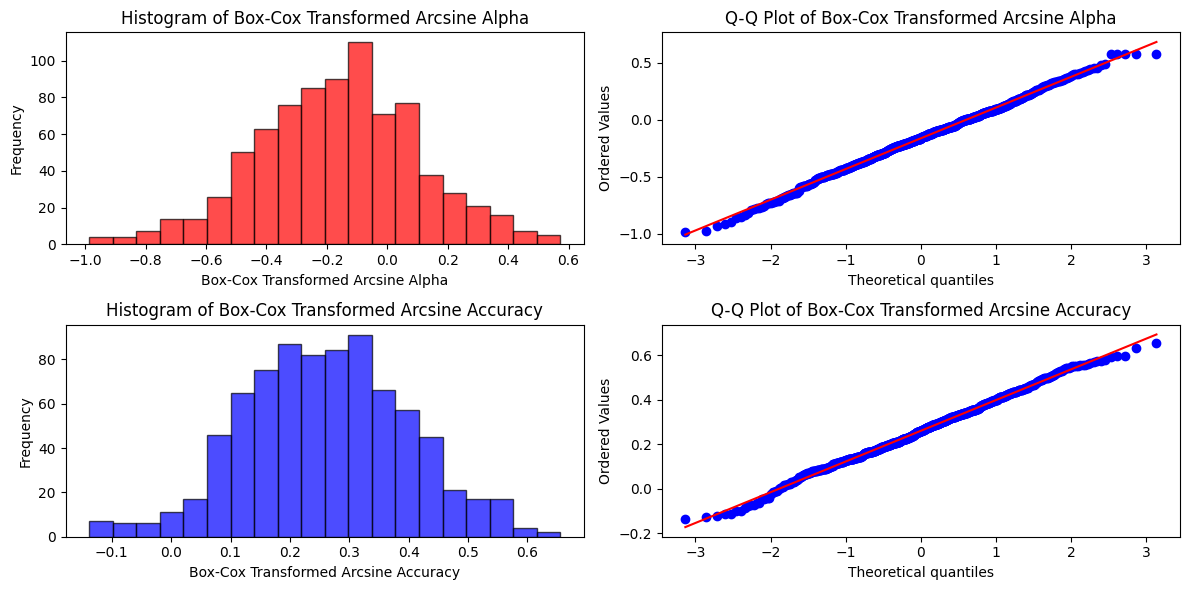

Alpha - Shapiro-Wilk Test p-value: 0.37087398767471313, Box-Cox Lambda: 1.0133293310706315
Accuracy Percentage - Shapiro-Wilk Test p-value: 0.16734077036380768, Box-Cox Lambda: 3.3512203329009562


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import shapiro, boxcox

# Load the data
file_path = 'EZ_recoverd_param_ELP_S1_second_100_2000_200_epoch_rt_acc_logAlphaSample.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Cap and shift the alpha values
data['alpha_capped'] = data['alpha'].clip(lower=1, upper=2)
data['alpha_shifted'] = data['alpha_capped'] - 1

# Apply the arcsine square root transformation to alpha
data['alpha_arcsin'] = np.arcsin(np.sqrt(data['alpha_shifted']))

# Add a small constant to ensure positivity for alpha
data['alpha_arcsin_positive'] = data['alpha_arcsin'] + 1e-6

# Apply the Box-Cox transformation to alpha
data['alpha_boxcox_after_arcsin'], fitted_lambda_alpha = boxcox(data['alpha_arcsin_positive'])

# Apply the arcsine square root transformation to accuracy_percentage
data['accuracy_arcsin'] = np.arcsin(np.sqrt(data['accuracy_percentage']))

# Add a small constant to ensure positivity for accuracy_percentage
data['accuracy_arcsin_positive'] = data['accuracy_arcsin'] + 1e-6

# Apply the Box-Cox transformation to accuracy_percentage
data['accuracy_boxcox_after_arcsin'], fitted_lambda_accuracy = boxcox(data['accuracy_arcsin_positive'])

# Perform Shapiro-Wilk Test for alpha
stat_alpha, p_alpha = shapiro(data['alpha_boxcox_after_arcsin'])

# Perform Shapiro-Wilk Test for accuracy_percentage
stat_accuracy, p_accuracy = shapiro(data['accuracy_boxcox_after_arcsin'])

# Plotting
plt.figure(figsize=(12, 6))

# Histogram for alpha
plt.subplot(2, 2, 1)
plt.hist(data['alpha_boxcox_after_arcsin'], bins=20, color='red', edgecolor='black', alpha=0.7)
plt.title('Histogram of Box-Cox Transformed Arcsine Alpha')
plt.xlabel('Box-Cox Transformed Arcsine Alpha')
plt.ylabel('Frequency')

# Q-Q plot for alpha
plt.subplot(2, 2, 2)
stats.probplot(data['alpha_boxcox_after_arcsin'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Box-Cox Transformed Arcsine Alpha')

# Histogram for accuracy_percentage
plt.subplot(2, 2, 3)
plt.hist(data['accuracy_boxcox_after_arcsin'], bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Box-Cox Transformed Arcsine Accuracy')
plt.xlabel('Box-Cox Transformed Arcsine Accuracy')
plt.ylabel('Frequency')

# Q-Q plot for accuracy_percentage
plt.subplot(2, 2, 4)
stats.probplot(data['accuracy_boxcox_after_arcsin'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Box-Cox Transformed Arcsine Accuracy')

plt.tight_layout()
plt.show()

# Print results
print(f"Alpha - Shapiro-Wilk Test p-value: {p_alpha}, Box-Cox Lambda: {fitted_lambda_alpha}")
print(f"Accuracy Percentage - Shapiro-Wilk Test p-value: {p_accuracy}, Box-Cox Lambda: {fitted_lambda_accuracy}")


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

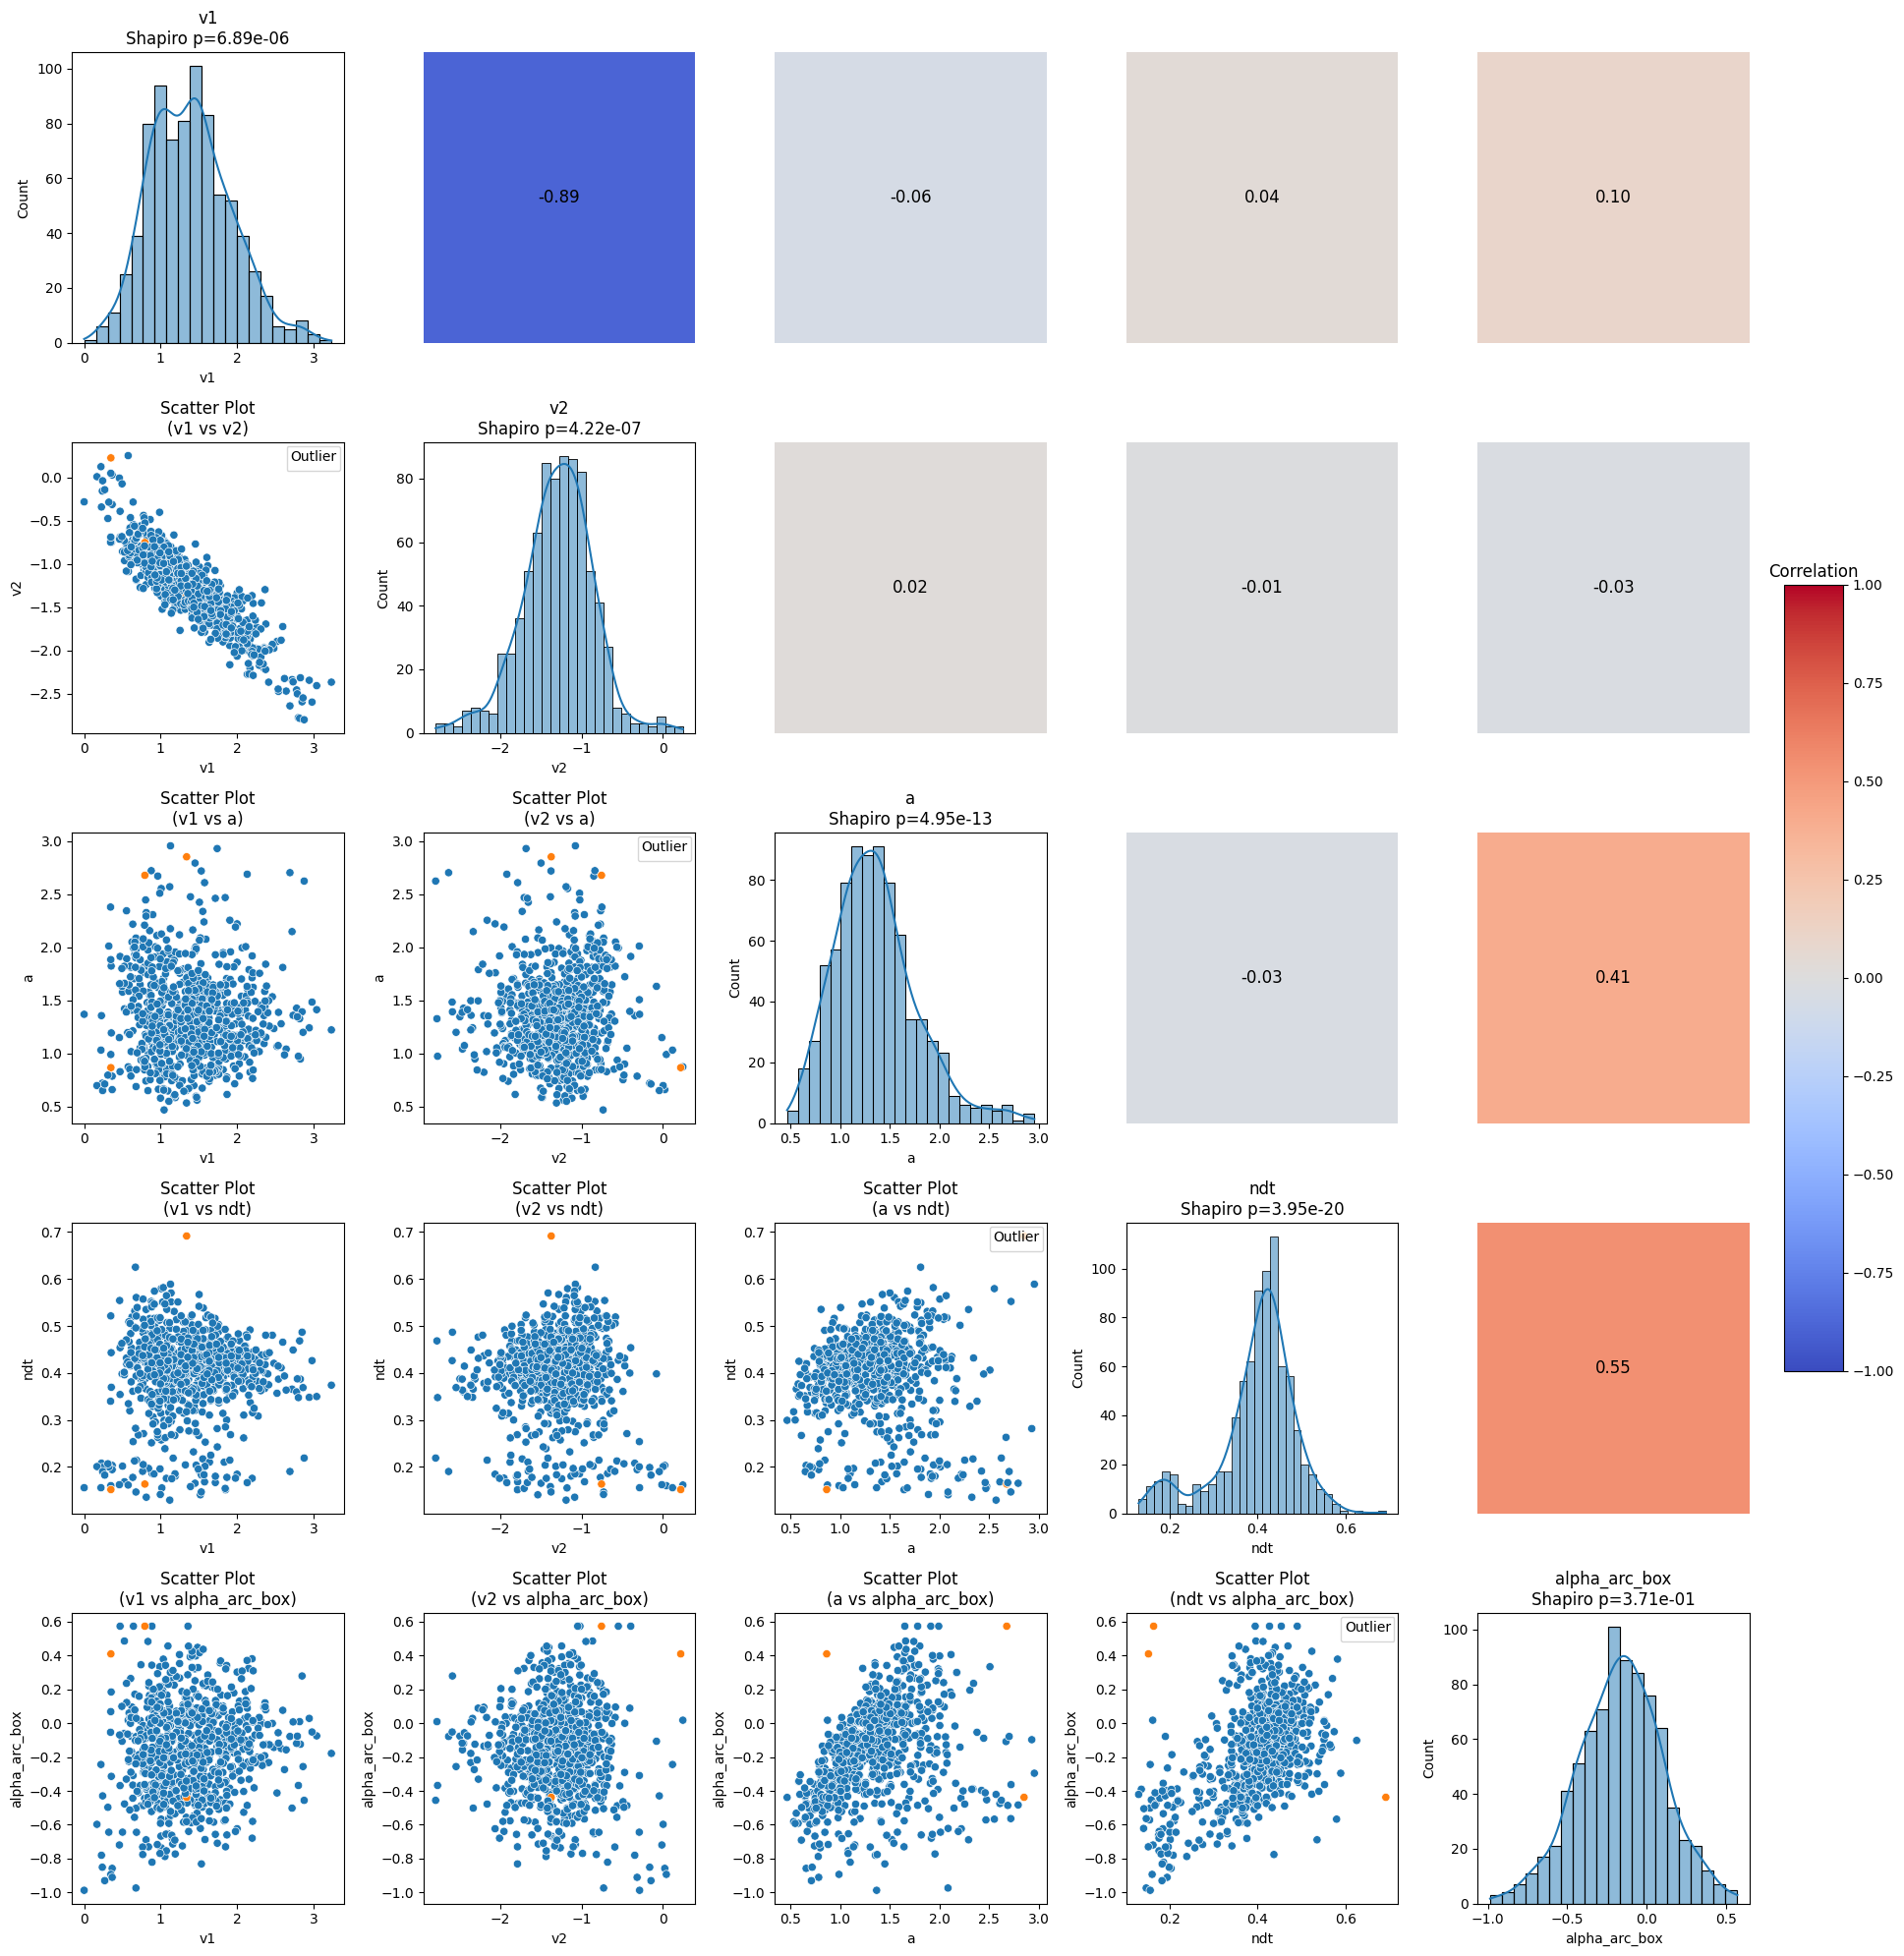

In [4]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

# Function to calculate Mahalanobis distance
def safe_mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Load your data
# data = pd.read_csv('Transformed_recoverd_param_ELP_S1_second_100_2000_200_epoch_rt_acc_logAlphaSample.csv')  # Replace with your file path

data = data
# Define your parameters
selected_params = ['v1', 'v2',# 'zr',
                   'a', 'ndt', #'sndt', 
                   #'alpha', 
                   'alpha_boxcox_after_arcsin', 
                  # 'mean_log_rt', 
                   #'accuracy_boxcox_after_arcsin'
                  ]

# Renaming for simplicity
renamed_params = {
    'v1': 'v1', 'v2': 'v2', #'zr': 'zr'
     'a': 'a', 
    'ndt': 'ndt', #'sndt': 'sndt',
    #'alpha': 'alpha', 
    'alpha_boxcox_after_arcsin': 'alpha_arc_box', 
   # 'mean_log_rt': 'mean_log_rt', 
  # 'accuracy_boxcox_after_arcsin': 'acc_arc_box'
}
data_renamed = data.rename(columns=renamed_params)

# Prepare for outlier detection and correlation
correlation_matrix = pd.DataFrame(index=selected_params, columns=selected_params)
p_value = 0.001

# Process each pair of parameters
for pair in combinations(selected_params, 2):
    pair_data = data[list(pair)]
    mahal_distances = safe_mahalanobis(x=pair_data, data=pair_data)
    threshold = stats.chi2.ppf((1 - p_value), df=2)
    outliers = mahal_distances > threshold
    correlation = pair_data[~outliers].corr().iloc[0, 1]
    correlation_matrix.loc[pair[0], pair[1]] = correlation
    correlation_matrix.loc[pair[1], pair[0]] = correlation

np.fill_diagonal(correlation_matrix.values, np.nan)
correlation_matrix_renamed = correlation_matrix.rename(columns=renamed_params, index=renamed_params)

# Shapiro-Wilk test
shapiro_results = {}
for param in selected_params:
    shapiro_test = stats.shapiro(data[param])
    shapiro_results[param] = shapiro_test[1]
shapiro_results_renamed = {renamed_params[key]: value for key, value in shapiro_results.items()}

# Create the visualization
# ... [rest of your code remains unchanged] ...

# Define the colormap for the heatmap
cmap = sns.color_palette("coolwarm", as_cmap=True)

# Create the visualization
fig, axn = plt.subplots(len(renamed_params), len(renamed_params), figsize=(20, 20))
cbar_ax = fig.add_axes([.91, .3, .03, .4])  # Adjust the position of the colorbar

for i, param_i in enumerate(renamed_params.values()):
    for j, param_j in enumerate(renamed_params.values()):
        ax = axn[i, j]
        if i == j:
            sns.histplot(data_renamed[param_i], kde=True, ax=ax)
            ax.set_title(f'{param_i}\nShapiro p={shapiro_results_renamed[param_i]:.2e}')
        elif i > j:
            sns.scatterplot(data=data_renamed, x=param_j, y=param_i, hue=outliers, legend=False, ax=ax)
            if i == j + 1:
                ax.legend(loc='upper right', title='Outlier', prop={'size': 6})
            ax.set_title(f'Scatter Plot\n({param_j} vs {param_i})')
        else:
            corr_value = correlation_matrix_renamed.iloc[i, j]
            color = cmap((corr_value + 1) / 2)
            ax.add_patch(plt.Rectangle((0, 0), 1, 1, color=color))
            ax.text(0.5, 0.5, f'{corr_value:.2f}', ha='center', va='center', fontsize=12)
            ax.axis('off')

# Create a colorbar
norm = plt.Normalize(vmin=-1, vmax=1)
fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cbar_ax.set_title('Correlation')

plt.tight_layout(rect=[0, 0, .9, 1])
plt.savefig('EZ_ELP_LDT_S1_correlation_matrix_heatMap_plot.png')  # Saves the plot to a file
plt.show()
plt.close()




In [2]:
import numpy as np
import scipy.stats as stats

# Define the safe Mahalanobis function
def safe_mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Let's apply this to the first pair of parameters and check the result
pair = ['v1', 'v2']
data_pair = data[pair]

# Calculating Mahalanobis distance for the pair
mahal_distances = safe_mahalanobis(x=data_pair, data=data_pair)

# Determine the p-value threshold for outlier detection (p < 0.001)
p_value_threshold = 0.001

# Calculate the critical value for this p-value under the chi-squared distribution
critical_value = stats.chi2.ppf((1 - p_value_threshold), df=2)

# Identifying outliers
outliers = mahal_distances > critical_value

# Display the first few Mahalanobis distances and the outlier flags
mahal_distances[:5], outliers[:5]


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


(array([2.26720179, 3.51514961, 1.79824719, 0.21866634, 7.48736054]),
 array([False, False, False, False, False]))

In [3]:
import numpy as np
import scipy.stats as stats

# Define the function for Mahalanobis distance
def safe_mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Select the first pair of parameters to demonstrate the process
params = ['v1', 'v2']
data_subset = data[params]

# Calculate the Mahalanobis distance for each observation
mahal_distances = safe_mahalanobis(x=data_subset, data=data_subset)

# Determine the threshold for outliers using the Chi-square distribution
p_value = 0.001
threshold = stats.chi2.ppf((1 - p_value), df=2)  # df is the number of variables, here 2

# Identify outliers
outliers = mahal_distances > threshold

# Print the number of outliers detected
num_outliers = np.sum(outliers)
num_outliers, threshold


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


(4, 13.815510557964274)

In [4]:
import numpy as np
import scipy.stats as stats

# Define the function for Mahalanobis distance
def safe_mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Select the first pair of parameters to demonstrate the process
params = ['v1', 'v2']
data_subset = data[params]

# Calculate the Mahalanobis distance for each observation
mahal_distances = safe_mahalanobis(x=data_subset, data=data_subset)

# Determine the threshold for outliers using the Chi-square distribution
p_value = 0.001
threshold = stats.chi2.ppf((1 - p_value), df=2)  # df is the number of variables, here 2

# Identify outliers
outliers = mahal_distances > threshold

# Print the number of outliers detected
num_outliers = np.sum(outliers)
num_outliers, threshold


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


(4, 13.815510557964274)

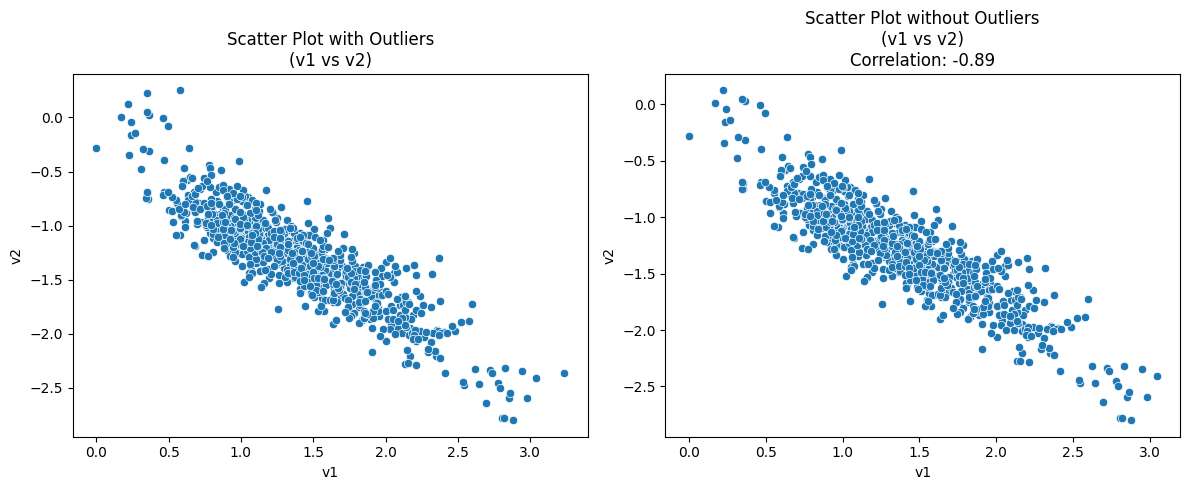

-0.8892911708019352

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Remove outliers for the first pair
data_no_outliers = data_subset[~outliers]

# Calculate correlation for the first pair without outliers
correlation = data_no_outliers.corr().iloc[0, 1]

# Plotting to show the process
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot with outliers
sns.scatterplot(data=data_subset, x=params[0], y=params[1], ax=ax[0])
ax[0].set_title(f'Scatter Plot with Outliers\n({params[0]} vs {params[1]})')

# Scatter plot without outliers
sns.scatterplot(data=data_no_outliers, x=params[0], y=params[1], ax=ax[1])
ax[1].set_title(f'Scatter Plot without Outliers\n({params[0]} vs {params[1]})\nCorrelation: {correlation:.2f}')

plt.tight_layout()
plt.show()

correlation


In [6]:
from itertools import combinations

# List of all selected parameters
selected_params = [
    'v1',
    'v2',
    # 'v_total = v2 - v1',
    # 'v_bias = v1 + v2',
   # 'zr',
    'a',
    'ndt',
    #'sndt',
    'alpha',
    'accuracy_percentage',
    'mean_log_rt',
    'alpha_boxcox_after_arcsin',
    'accuracy_boxcox_after_arcsin'
]
# Preparing a DataFrame to store correlations
correlation_matrix = pd.DataFrame(index=selected_params, columns=selected_params)

# Calculate Mahalanobis distance and correlations for each pair of parameters
for pair in combinations(selected_params, 2):
    pair_data = data[list(pair)]
    mahal_distances = safe_mahalanobis(x=pair_data, data=pair_data)
    outliers = mahal_distances > threshold
    correlation = pair_data[~outliers].corr().iloc[0, 1]
    correlation_matrix.loc[pair[0], pair[1]] = correlation
    correlation_matrix.loc[pair[1], pair[0]] = correlation  # Mirror the matrix

# Fill diagonal with NaN as we will put histograms there
np.fill_diagonal(correlation_matrix.values, np.nan)

correlation_matrix.head()  # Displaying the first few rows for review


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

v1        v2         a       ndt     alpha accuracy_percentage  \
v1          NaN -0.889291 -0.061871  0.036799  0.107225            0.764713   
v2    -0.889291       NaN  0.021326 -0.014792  -0.05762            -0.74053   
a     -0.061871  0.021326       NaN -0.034737  0.394207            0.100212   
ndt    0.036799 -0.014792 -0.034737       NaN  0.558989            0.422699   
alpha  0.107225  -0.05762  0.394207  0.558989       NaN            0.551374   

      mean_log_rt alpha_boxcox_after_arcsin accuracy_boxcox_after_arcsin  
v1      -0.450311                  0.095926                     0.818687  
v2       0.462736                  -0.02926                    -0.783901  
a        0.774634                  0.405033                      0.15806  
ndt      0.461389                  0.545199                     0.399993  
alpha    0.504777                  0.996885                     0.537968

In [7]:
for pair in combinations(selected_params, 2):
    print(pair)

('v1', 'v2')
('v1', 'a')
('v1', 'ndt')
('v1', 'alpha')
('v1', 'accuracy_percentage')
('v1', 'mean_log_rt')
('v1', 'alpha_boxcox_after_arcsin')
('v1', 'accuracy_boxcox_after_arcsin')
('v2', 'a')
('v2', 'ndt')
('v2', 'alpha')
('v2', 'accuracy_percentage')
('v2', 'mean_log_rt')
('v2', 'alpha_boxcox_after_arcsin')
('v2', 'accuracy_boxcox_after_arcsin')
('a', 'ndt')
('a', 'alpha')
('a', 'accuracy_percentage')
('a', 'mean_log_rt')
('a', 'alpha_boxcox_after_arcsin')
('a', 'accuracy_boxcox_after_arcsin')
('ndt', 'alpha')
('ndt', 'accuracy_percentage')
('ndt', 'mean_log_rt')
('ndt', 'alpha_boxcox_after_arcsin')
('ndt', 'accuracy_boxcox_after_arcsin')
('alpha', 'accuracy_percentage')
('alpha', 'mean_log_rt')
('alpha', 'alpha_boxcox_after_arcsin')
('alpha', 'accuracy_boxcox_after_arcsin')
('accuracy_percentage', 'mean_log_rt')
('accuracy_percentage', 'alpha_boxcox_after_arcsin')
('accuracy_percentage', 'accuracy_boxcox_after_arcsin')
('mean_log_rt', 'alpha_boxcox_after_arcsin')
('mean_log_rt', 'a

/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

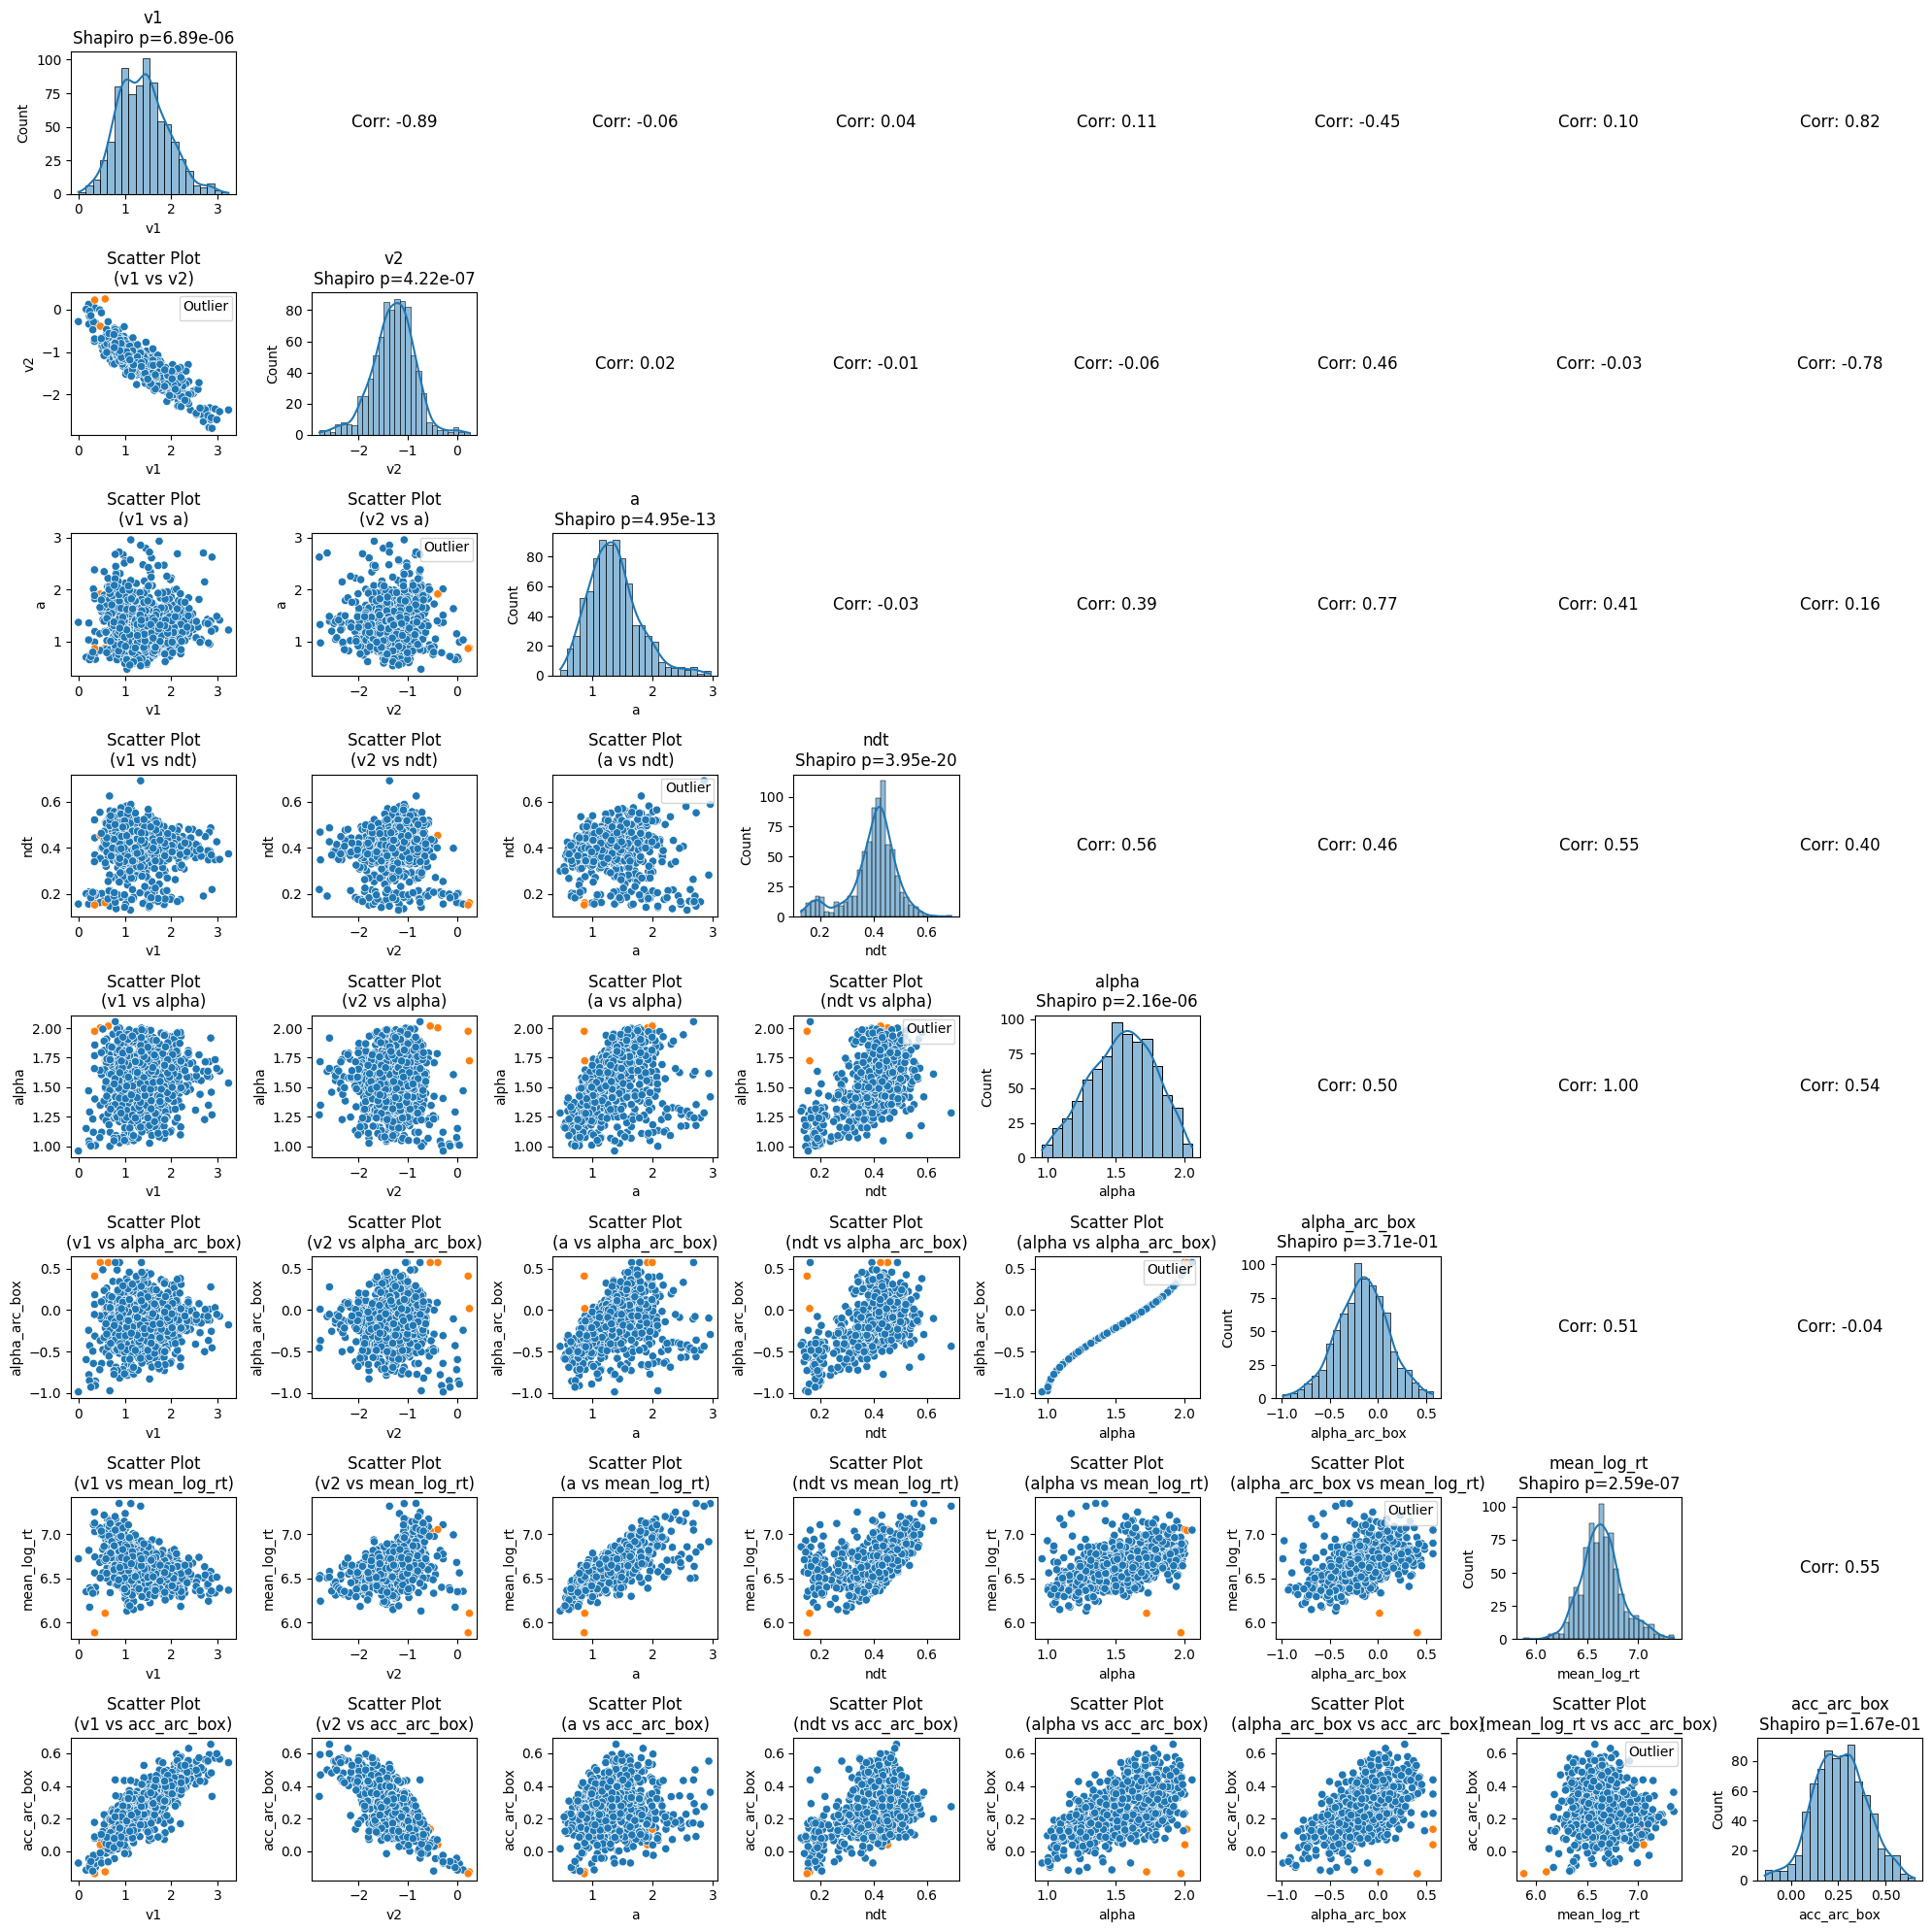

In [9]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

# Function to calculate Mahalanobis distance
def safe_mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Load your data
data = data  # Replace with your file path

# Define your parameters
selected_params = [
    'v1',
    'v2',
    # 'v_total = v2 - v1',
    # 'v_bias = v1 + v2',
   # 'zr',
    'a',
    'ndt',
    #'sndt',
    'alpha',
    'mean_log_rt',
    'alpha_boxcox_after_arcsin',
    'accuracy_boxcox_after_arcsin'
]
# Renaming for simplicity
renamed_params = {
    'v1': 'v1', 'v2': 'v2',  'a': 'a', 
    'ndt': 'ndt', 'alpha': 'alpha', 
    ''
    'alpha_boxcox_after_arcsin': 'alpha_arc_box', 
    'mean_log_rt': 'mean_log_rt', 
    'accuracy_boxcox_after_arcsin': 'acc_arc_box'
}
data_renamed = data.rename(columns=renamed_params)

# Prepare for outlier detection and correlation
correlation_matrix = pd.DataFrame(index=selected_params, columns=selected_params)
p_value = 0.001

# Process each pair of parameters
for pair in combinations(selected_params, 2):
    pair_data = data[list(pair)]
    mahal_distances = safe_mahalanobis(x=pair_data, data=pair_data)
    threshold = stats.chi2.ppf((1 - p_value), df=2)
    outliers = mahal_distances > threshold
    correlation = pair_data[~outliers].corr().iloc[0, 1]
    correlation_matrix.loc[pair[0], pair[1]] = correlation
    correlation_matrix.loc[pair[1], pair[0]] = correlation

np.fill_diagonal(correlation_matrix.values, np.nan)
correlation_matrix_renamed = correlation_matrix.rename(columns=renamed_params, index=renamed_params)

# Shapiro-Wilk test
shapiro_results = {}
for param in selected_params:
    shapiro_test = stats.shapiro(data[param])
    shapiro_results[param] = shapiro_test[1]
shapiro_results_renamed = {renamed_params[key]: value for key, value in shapiro_results.items()}

# Create the visualization
plt.figure(figsize=(20, 20))
for i, param_i in enumerate(renamed_params.values()):
    for j, param_j in enumerate(renamed_params.values()):
        plt.subplot(len(renamed_params), len(renamed_params), i*len(renamed_params) + j + 1)
        if i == j:
            sns.histplot(data_renamed[param_i], kde=True)
            plt.title(f'{param_i}\nShapiro p={shapiro_results_renamed[param_i]:.2e}')
        elif i > j:
            scatter_plot = sns.scatterplot(data=data_renamed, x=param_j, y=param_i, hue=outliers, legend=False)
            if i == j + 1:
                scatter_plot.legend(loc='upper right', title='Outlier', prop={'size': 6})
            plt.title(f'Scatter Plot\n({param_j} vs {param_i})')
        else:
            plt.text(0.5, 0.5, f'Corr: {correlation_matrix_renamed.iloc[i, j]:.2f}', 
                     horizontalalignment='center', verticalalignment='center', fontsize=12)
            plt.axis('off')

plt.tight_layout()
plt.savefig('ELP_S1_correlation_matrix_plot.png')  # Saves the plot to a file
plt.show()
plt.close()



In [10]:
correlation_matrix_renamed.to_csv('EZ_ELP_s1_correlation_matrix_renamed.csv')

/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

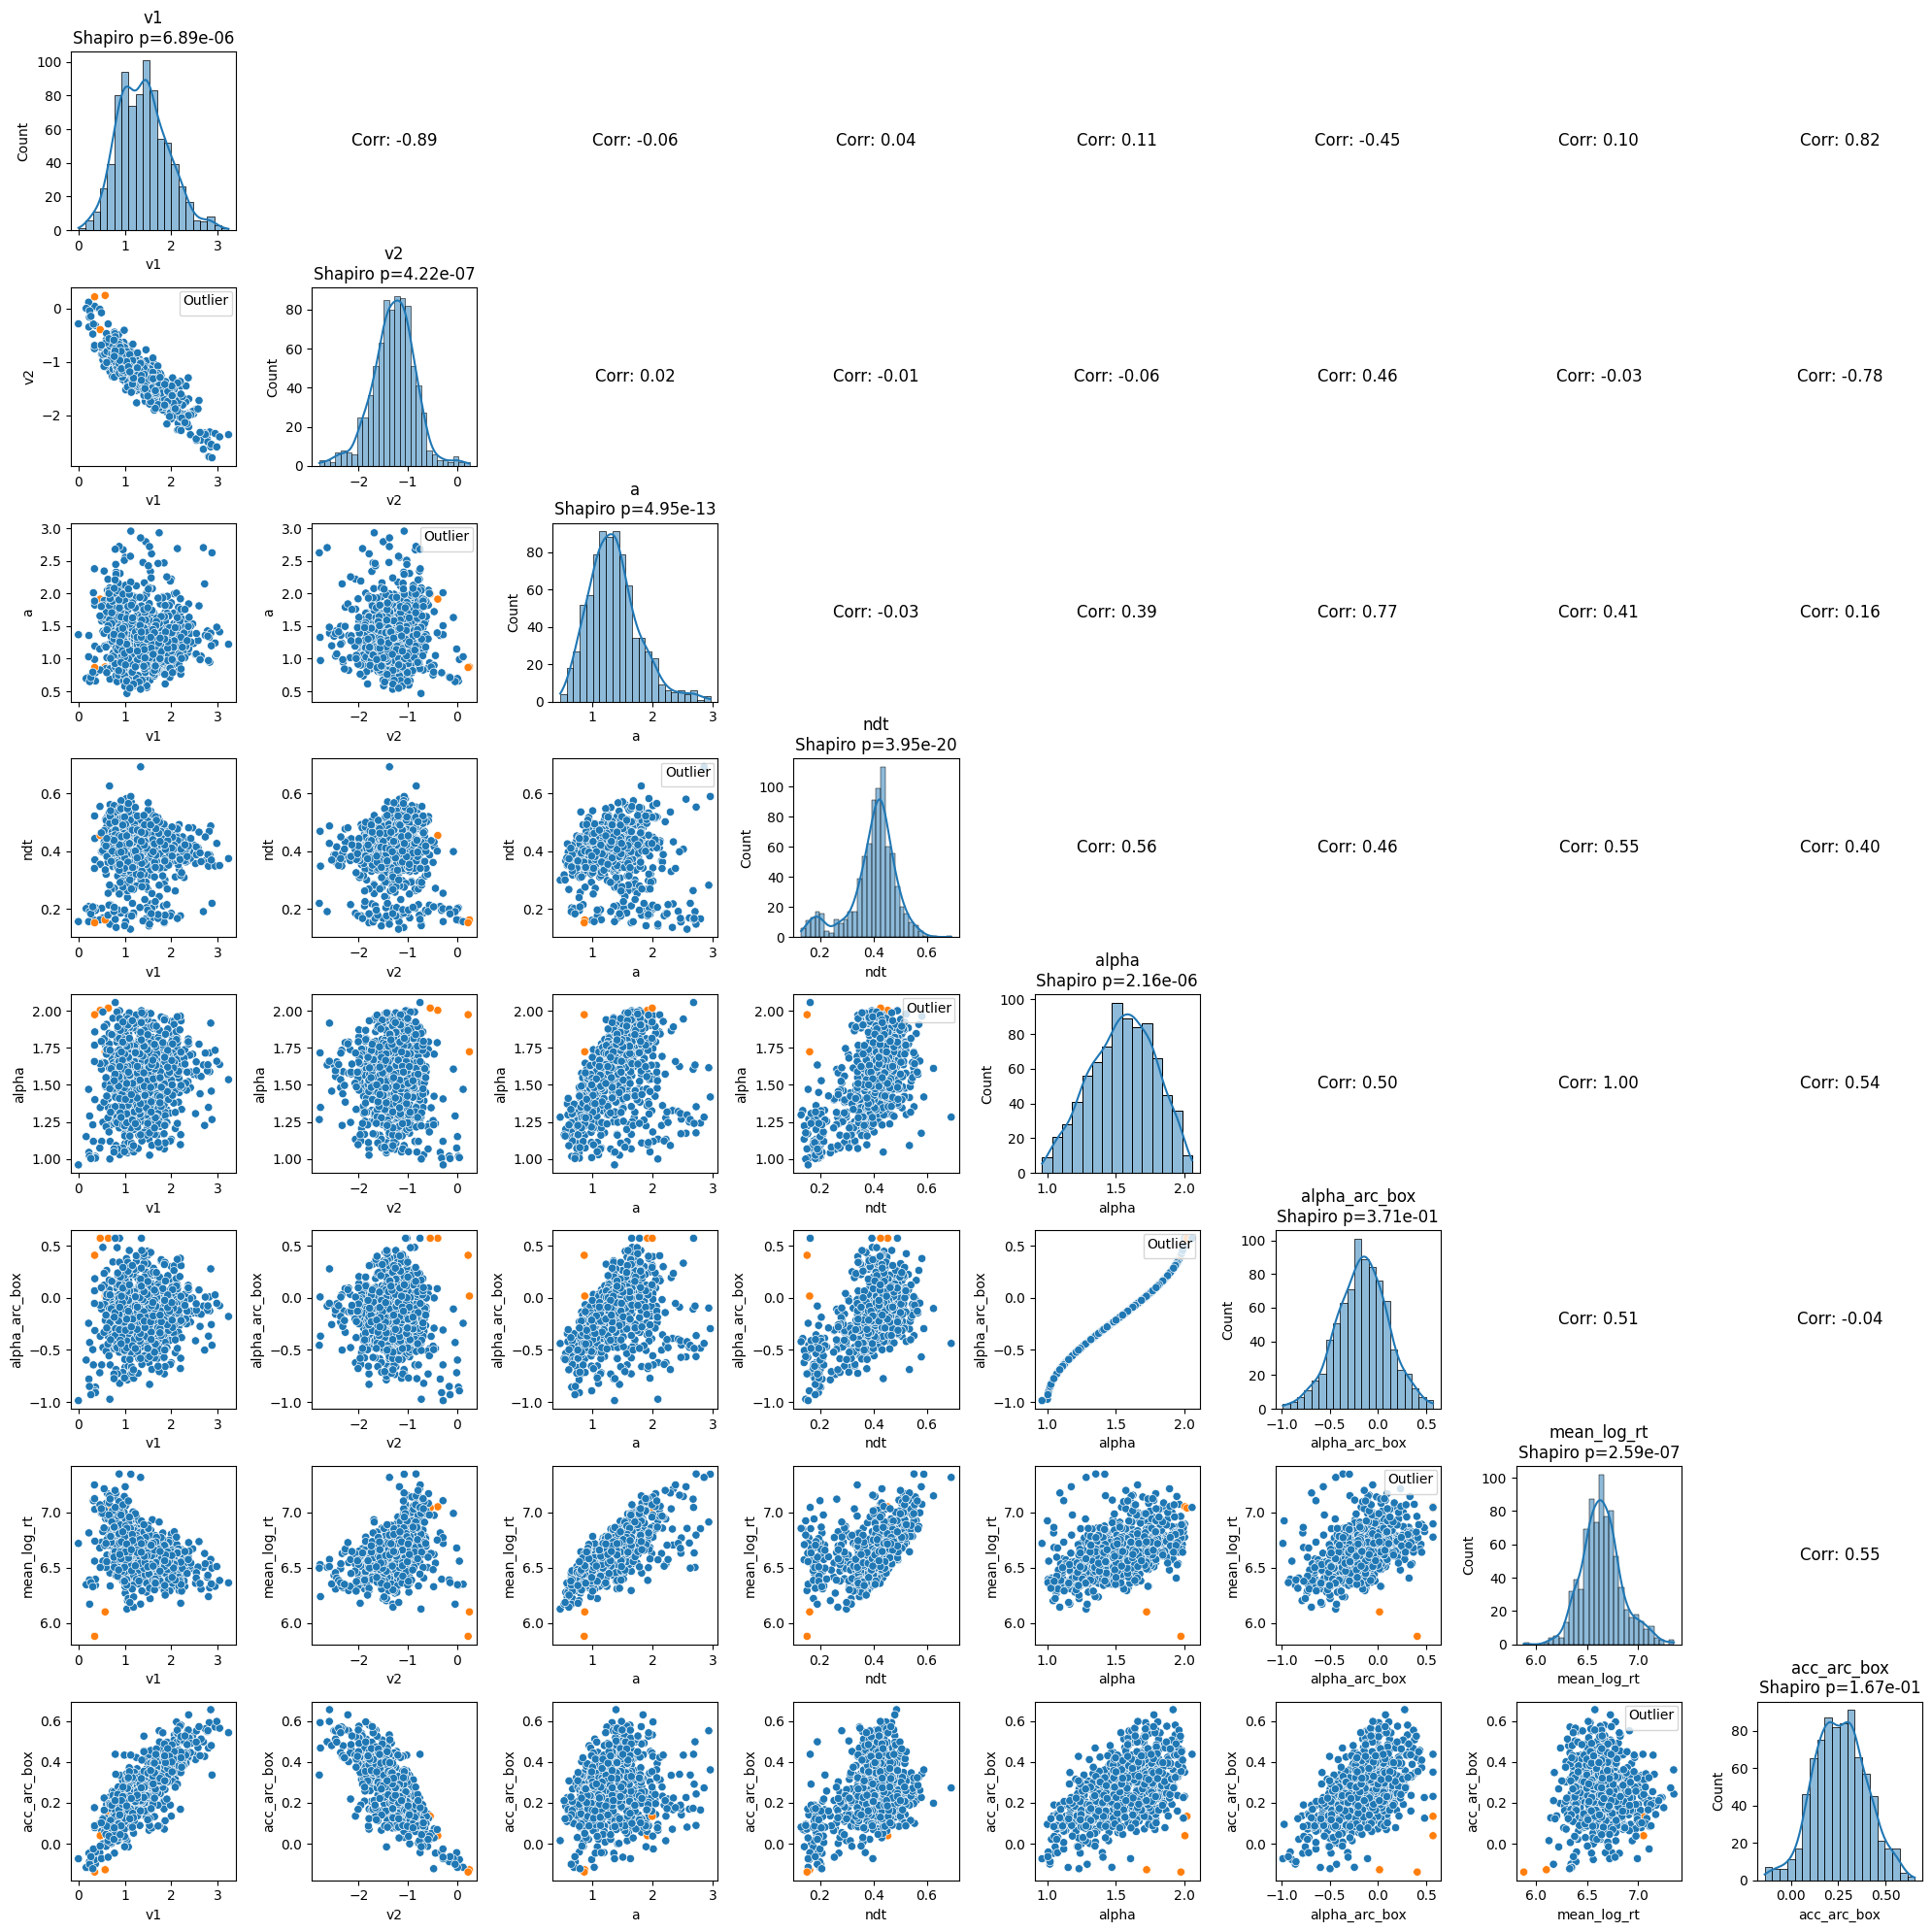

In [19]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

# Function to calculate Mahalanobis distance
def safe_mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Load your data
data = data  # Replace with your file path

# Define your parameters
selected_params = selected_params = [ 'v1',
    'v2',
    # 'v_total = v2 - v1',
    # 'v_bias = v1 + v2',
    #'zr',
    'a',
    'ndt',
    #'sndt',
    'alpha',
    'mean_log_rt',
    'alpha_boxcox_after_arcsin',
    'accuracy_boxcox_after_arcsin']

# Renaming for simplicity
renamed_params = renamed_params =  {
    'v1': 'v1', 'v2': 'v2',  'a': 'a', 
    'ndt': 'ndt',  'alpha': 'alpha', 
    ''
    'alpha_boxcox_after_arcsin': 'alpha_arc_box', 
    'mean_log_rt': 'mean_log_rt', 
    'accuracy_boxcox_after_arcsin': 'acc_arc_box'
}
   
data_renamed = data.rename(columns=renamed_params)

# Prepare for outlier detection and correlation
correlation_matrix = pd.DataFrame(index=selected_params, columns=selected_params)
p_value = 0.001

# Process each pair of parameters
for pair in combinations(selected_params, 2):
    pair_data = data[list(pair)]
    mahal_distances = safe_mahalanobis(x=pair_data, data=pair_data)
    threshold = stats.chi2.ppf((1 - p_value), df=2)
    outliers = mahal_distances > threshold
    correlation = pair_data[~outliers].corr().iloc[0, 1]
    correlation_matrix.loc[pair[0], pair[1]] = correlation
    correlation_matrix.loc[pair[1], pair[0]] = correlation

np.fill_diagonal(correlation_matrix.values, np.nan)
correlation_matrix_renamed = correlation_matrix.rename(columns=renamed_params, index=renamed_params)

# Shapiro-Wilk test
shapiro_results = {}
for param in selected_params:
    shapiro_test = stats.shapiro(data[param])
    shapiro_results[param] = shapiro_test[1]
shapiro_results_renamed = {renamed_params[key]: value for key, value in shapiro_results.items()}

# Create the visualization
plt.figure(figsize=(20, 20))
for i, param_i in enumerate(renamed_params.values()):
    for j, param_j in enumerate(renamed_params.values()):
        plt.subplot(len(renamed_params), len(renamed_params), i*len(renamed_params) + j + 1)
        if i == j:
            sns.histplot(data_renamed[param_i], kde=True)
            plt.title(f'{param_i}\nShapiro p={shapiro_results_renamed[param_i]:.2e}')
        elif i > j:
            scatter_plot = sns.scatterplot(data=data_renamed, x=param_j, y=param_i, hue=outliers, legend=False)
            if i == j + 1:
                scatter_plot.legend(loc='upper right', title='Outlier', prop={'size': 6})
            #plt.title(f'Scatter Plot\n({param_j} vs {param_i})')
        else:
            plt.text(0.5, 0.5, f'Corr: {correlation_matrix_renamed.iloc[i, j]:.2f}', 
                     horizontalalignment='center', verticalalignment='center', fontsize=12)
            plt.axis('off')

plt.tight_layout()
plt.show()

plt.savefig('EZ_ELP_s1_exclude_sndt_alphaMean_correlation_matrix_plot.png')  # Saves the plot to a file
plt.close()



/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

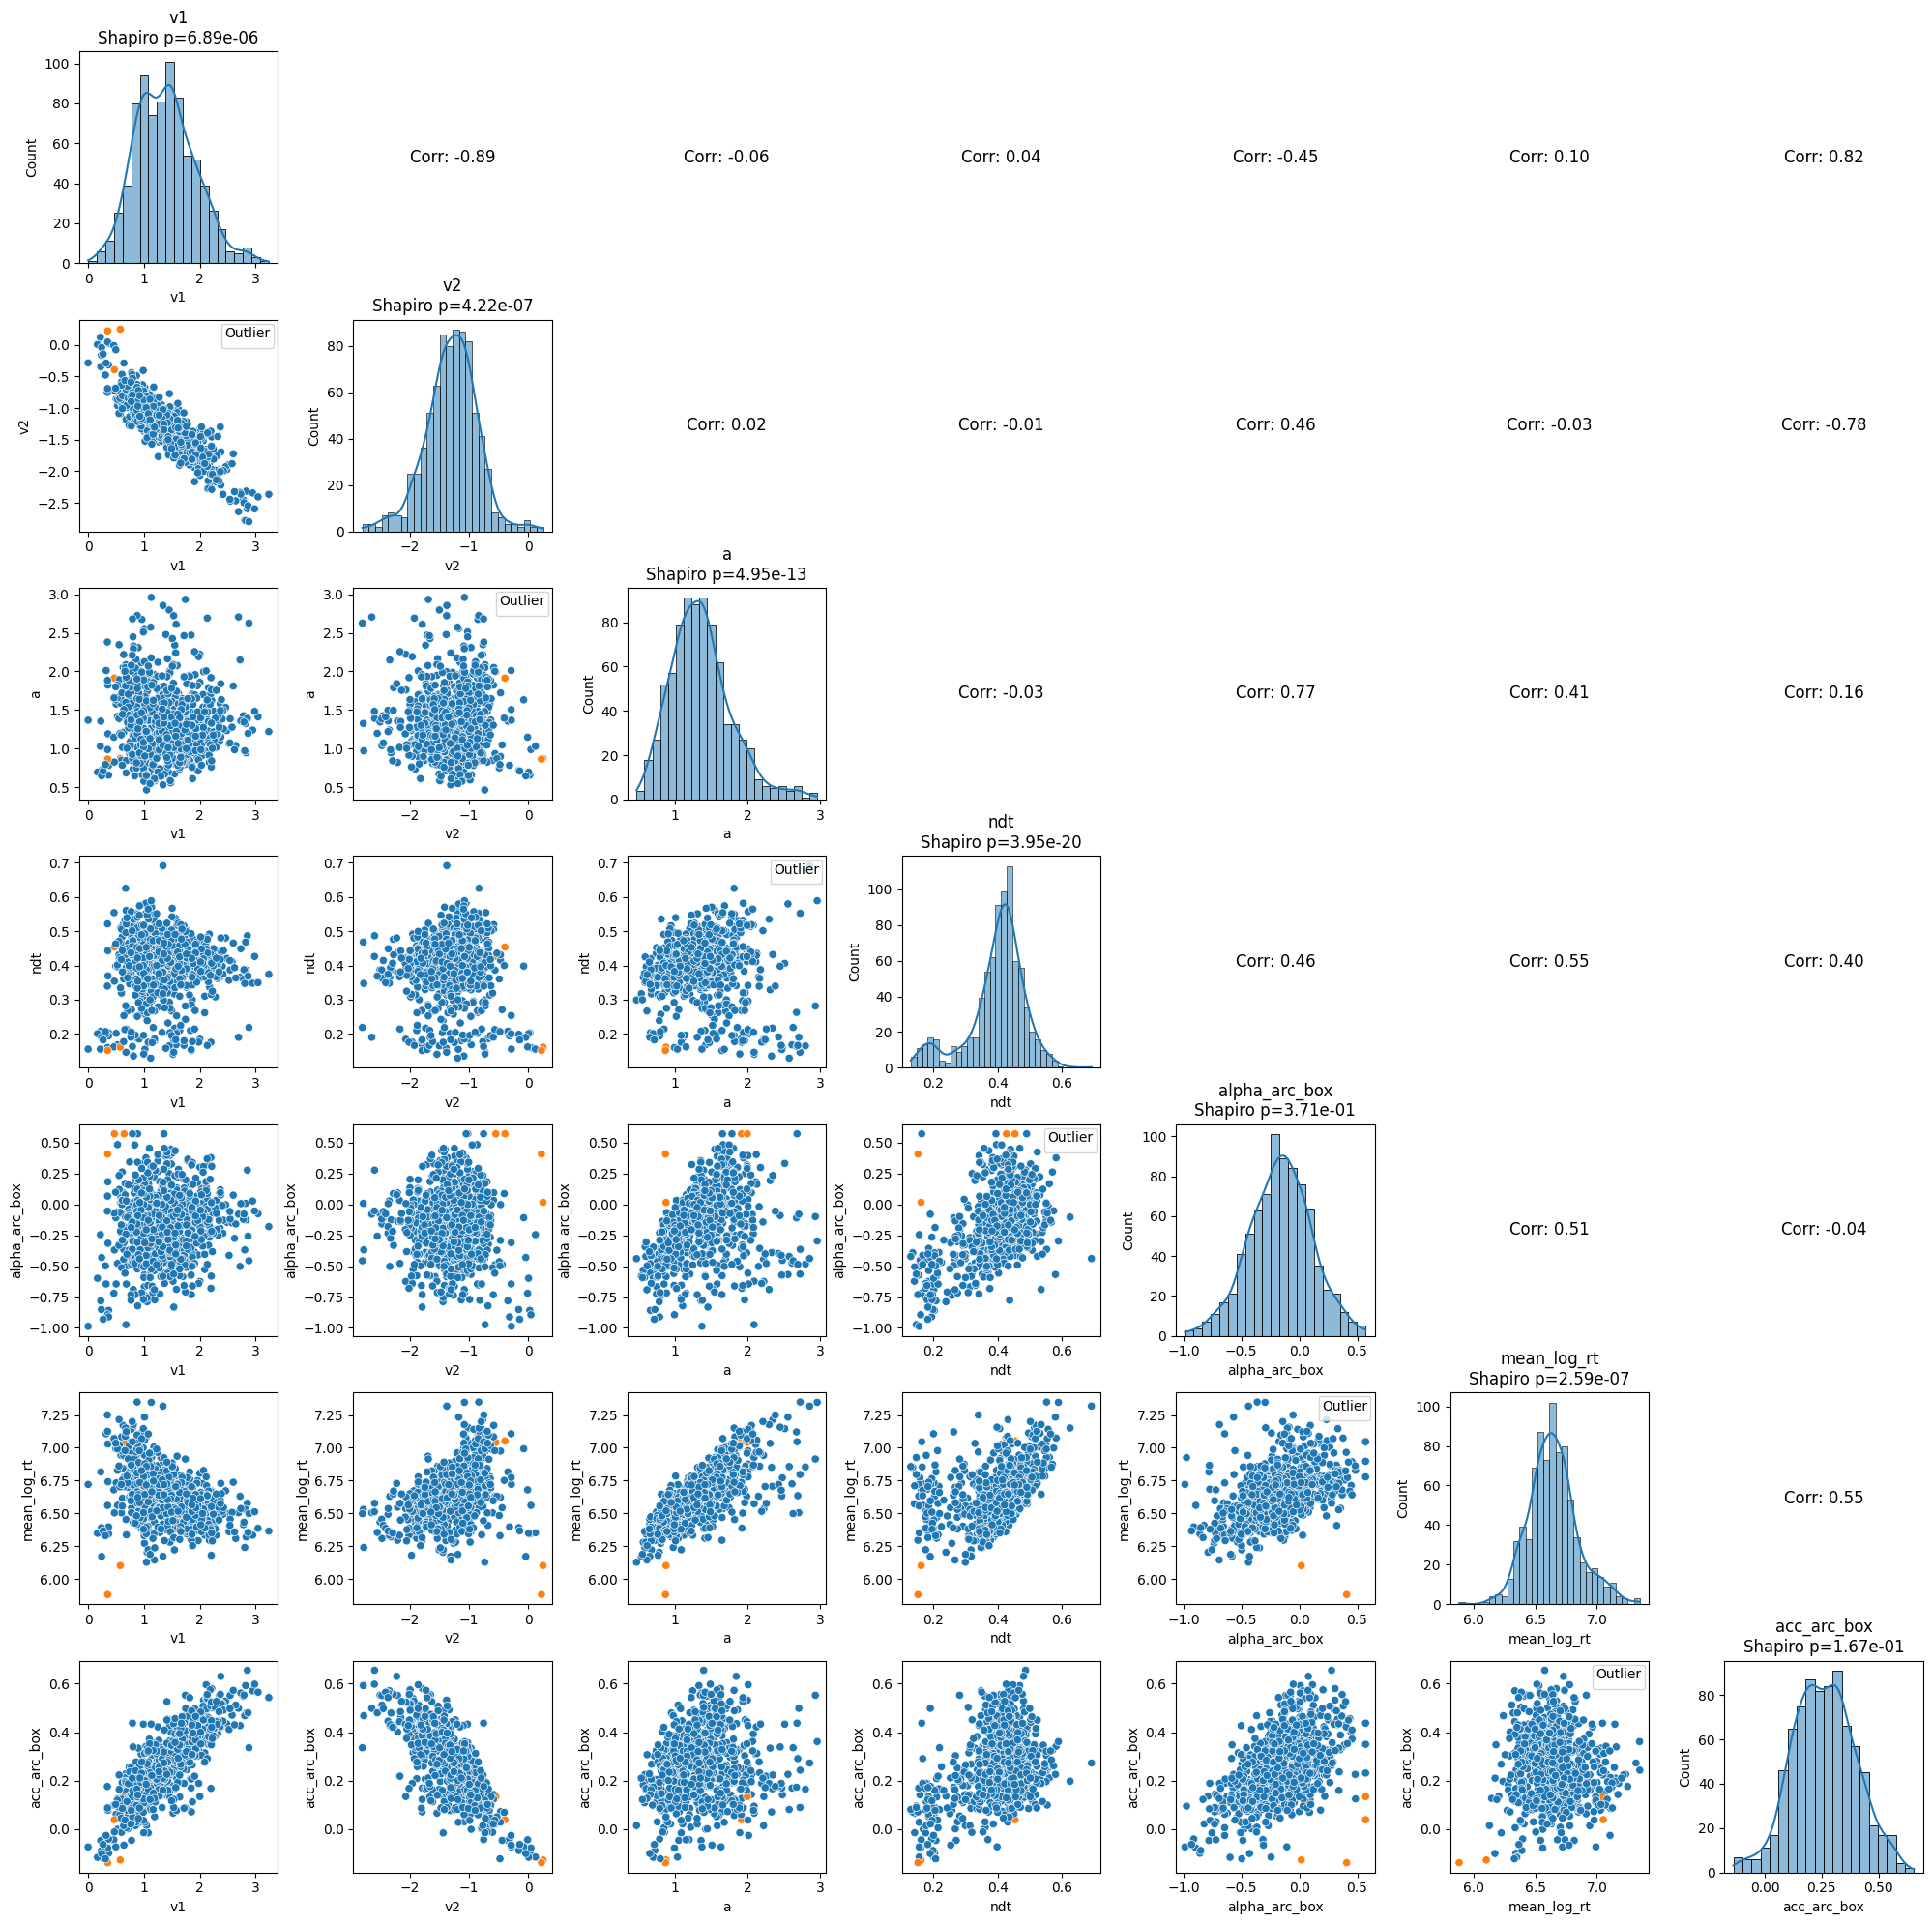

In [14]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

# Function to calculate Mahalanobis distance
def safe_mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Load your data
data =data  # Replace with your file path

# Define your parameters
selected_params = [ 'v1',
    'v2',
    # 'v_total = v2 - v1',
    # 'v_bias = v1 + v2',
    #'zr',
    'a',
    'ndt',
    #'sndt',
    #'alpha',
    'mean_log_rt',
    'alpha_boxcox_after_arcsin',
    'accuracy_boxcox_after_arcsin']

# Renaming for simplicity
renamed_params =  {
    'v1': 'v1', 'v2': 'v2',  'a': 'a', 
    'ndt': 'ndt',# 'sndt': 'sndt', 'alpha': 'alpha', 
    ''
    'alpha_boxcox_after_arcsin': 'alpha_arc_box', 
    'mean_log_rt': 'mean_log_rt', 
    'accuracy_boxcox_after_arcsin': 'acc_arc_box'
}
   

data_renamed = data.rename(columns=renamed_params)

# Prepare for outlier detection and correlation
correlation_matrix = pd.DataFrame(index=selected_params, columns=selected_params)
p_value = 0.001

# Process each pair of parameters
for pair in combinations(selected_params, 2):
    pair_data = data[list(pair)]
    mahal_distances = safe_mahalanobis(x=pair_data, data=pair_data)
    threshold = stats.chi2.ppf((1 - p_value), df=2)
    outliers = mahal_distances > threshold
    correlation = pair_data[~outliers].corr().iloc[0, 1]
    correlation_matrix.loc[pair[0], pair[1]] = correlation
    correlation_matrix.loc[pair[1], pair[0]] = correlation

np.fill_diagonal(correlation_matrix.values, np.nan)
correlation_matrix_renamed = correlation_matrix.rename(columns=renamed_params, index=renamed_params)

# Shapiro-Wilk test
shapiro_results = {}
for param in selected_params:
    shapiro_test = stats.shapiro(data[param])
    shapiro_results[param] = shapiro_test[1]
shapiro_results_renamed = {renamed_params[key]: value for key, value in shapiro_results.items()}

# Create the visualization
plt.figure(figsize=(20, 20))
for i, param_i in enumerate(renamed_params.values()):
    for j, param_j in enumerate(renamed_params.values()):
        plt.subplot(len(renamed_params), len(renamed_params), i*len(renamed_params) + j + 1)
        if i == j:
            sns.histplot(data_renamed[param_i], kde=True)
            plt.title(f'{param_i}\nShapiro p={shapiro_results_renamed[param_i]:.2e}')
        elif i > j:
            scatter_plot = sns.scatterplot(data=data_renamed, x=param_j, y=param_i, hue=outliers, legend=False)
            if i == j + 1:
                scatter_plot.legend(loc='upper right', title='Outlier', prop={'size': 6})
            #plt.title(f'Scatter Plot\n({param_j} vs {param_i})')
        else:
            plt.text(0.5, 0.5, f'Corr: {correlation_matrix_renamed.iloc[i, j]:.2f}', 
                     horizontalalignment='center', verticalalignment='center', fontsize=12)
            plt.axis('off')

plt.tight_layout()
plt.show()

plt.savefig('EZ_ELP_S1_exclude_sndt_alphaMean_zr_correlation_matrix_plot.png')  # Saves the plot to a file
plt.close()

